# 1a

Note that I have used $\sigma$ to represent the density of trees pr. unit area instead of $n$. I didn't notice it before I had already written most of the code, so I haven't bothered to change it.  

Besides, using $n$ for density just feels weird :)

## 1.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # For tracking progress of loops

These are some helper functions that will be used at various points throughout the assignment.

In [21]:
def generateRandomPointInCircle(R):
    '''Generates a random point within a circle of radius R centered at the origin.'''
    theta = np.random.uniform(0, 2 * np.pi)
    r = R * np.sqrt(np.random.uniform(0, 1))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return (x, y)

def distance(x1, y1, x2, y2):
        '''Gets the distance between (x1, y1) and (x2, y2).'''
        return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def distToLine(a, b, x0, y0):
    '''Calculates the distance from (x0, y0) to the line y = a x + b'''
    return np.abs(a*x0 + b - y0)/np.sqrt(1 + a**2)

def line_circleIntersection(a, b, x_C, y_C, R):
    '''
    Takes in the parameters defining a line and a circle and finds the point of intersection closest to the origin.
    
    Returns the point of intersection as a tuple (x,y)
    '''
    # These coefficients are derived in section 2
    A = a**2 + 1
    B = 2*a*b -2*a*y_C -2*x_C
    C = -R**2 +b**2 -2*b*y_C +x_C**2 +y_C**2

    discriminant = B**2 - 4*A*C
    if discriminant < 0:
        raise ValueError("No intersection found!") # For debugging
    
    x1 = (-B + np.sqrt(discriminant)) / (2*A)
    y1 = a*x1 + b
    x2 = (-B - np.sqrt(discriminant)) / (2*A)
    y2 = a*x2 + b

    # We return the point closest to the origin
    if distance(x1, y1, 0, 0) < distance(x2, y2, 0, 0):
        return (x1, y1)
    else:
        return (x2, y2)

def mergeForests(forest1, forest2):
    '''Takes two forests and returns a single forest containing all their trees.'''
    res = []

    for tree in forest1:
        res.append(tree)
    for tree in forest2:
        res.append(tree)
        
    return res

def chiSquared(observed, expected, errors):
    '''Calculates the chi-squared value given lists of observed, expected, and error values.'''
    return np.sum(((observed - expected) / errors) ** 2)



We'll represent the trees with a class, containing information about their position, diameter, color, etc. We'll also add some logic for sorting our trees based on their distance from the origin.

In [22]:
class Tree:
    def setOriginDistance(self, d):
        '''
        Sets the distance of self to the origin to d
        
        NB: This doesn't change the position of the Tree!
        '''
        self.origin_dist = d

    def setDiameter(self, D):
        '''Sets diameter of self to D.'''
        self.diameter = D
        
    def setPosition(self, x, y):
        '''Sets position of self to (x,y).'''
        self.x_pos = x
        self.y_pos = y

    def setArgument(self, theta):
        '''Sets the angle between self and the x-axis to theta. Equivalent to the argument of a complex number.'''
        self.arg = theta

    def setColor(self, color):
        '''Sets the color of the tree to color.'''
        self.color = color

    def __lt__(self, other):
        '''For sorting purposes. Returns True if self is closer to the origin than other, False otherwise.'''
        return self.origin_dist < other.origin_dist


            

If the forest is big enough, it is impossible to tell whether you are at the center or not just by looking around. This means we can safely assume that Robin Hood is always at the center, so we simply place him at the origin and generate a circular forest around him, making sure not to place any trees at the origin.  

But we can't just generate a forest with a predetermined size, since we don't know how far the arrow needs to travel before it hits a tree. Instead, let's proceed by procedurally generating rings of forest with a certain thickness at some distance from the origin. 

We can then start by generating a ring at distance 0, i.e. a circle around the origin, and add more rings of forest as required until the arrow hits something. Of course, we will need to pass our old forest as an argument to the generating function, since we need to avoid placing new trees on top of existing ones.

In [23]:
# We use the values from Ryden's book as our default values
def generateForest(sigma=0.005, D=2, R=0, dR=10, old_forest=[]):
    '''
    Generates a 2d forest of trees placed randomly (uniformly) in a ring centered on the origin. If used with an existing forest, returns both the old forest and the new trees placed.

    Parameters:
    sigma: The density of trees measured in trees pr. unit area
    D: The diameter of the trees in the forest
    R: The distance from the origin at which the ring will begin
    dR: The thickness of the ring
    old_forest: An existing forest (list of trees) to append the new one to
    
    Returns a nested list of Tree objects, containing the trees in the old forest and the trees in the new ring.
    '''
    # Calculate the area of the ring and the number of trees to place
    area = np.pi*((R + dR)**2 - R**2)
    n_trees = int(sigma*area)

    added_forest_ring = []

    while len(added_forest_ring) < n_trees:
        # Get random position for the new tree
        theta = np.random.uniform(0, 2*np.pi)
        r = np.random.uniform(R, R + dR)
        x = r*np.cos(theta)
        y = r*np.sin(theta)

        # Check if the new tree touches any trees in the old forest or any of the newly generated trees
        # We also make sure not to place any trees at the origin
        # I'm using all() which returns True iff all elements of a list are True
        if all(distance(x, y, tree.x_pos, tree.y_pos) >= D for tree in old_forest) and all(distance(x, y, tree.x_pos, tree.y_pos) >= D for tree in added_forest_ring) and r > D: 
            # If the position obeys the conditions we instantiate a new tree there and append it to the list
            new_tree = Tree()
            new_tree.setDiameter(D)
            new_tree.setPosition(x, y)
            new_tree.setOriginDistance(r)
            new_tree.setArgument(theta)
            new_tree.setColor('green')

            added_forest_ring.append(new_tree)

    return [old_forest, added_forest_ring]
        



I've decided to have the function return the old and new forest seperately for the sake of efficiency. This way, when we look for collisions with the arrow, we will be able to check only the newly generated trees instead of looping over all of the ones that are behind the arrow.  

It would be nice to have a plot of the forest, so let's add a function for that. We'll also add the option to plot the trajectory of the arrow.

In [24]:
def plotForest(forest, theta=None, arrow_distance=None):
    '''
    Plots a forest of trees. 
    
    If given an angle theta and a distance arrow_distance, it will also plot an arrow from the origin to the point (arrow_distance, theta).
    '''
    # Used to avoid setting the tree label multiple times
    tree_label_has_been_set = False

    # Radius of the forest
    R = 0

    # The trees are represented by filled in circles
    for tree in forest:
        if tree_label_has_been_set:
            circle = plt.Circle((tree.x_pos, tree.y_pos), tree.diameter/2, color=tree.color, fill=True)
        else:
            circle = plt.Circle((tree.x_pos, tree.y_pos), tree.diameter/2, color=tree.color, fill=True, label='Tree')
            tree_label_has_been_set = True

        # Keep track of the radius of the forest by checking how far away the furthest tree from the origin is
        current_dist = distance(tree.x_pos, tree.y_pos, 0, 0)
        if current_dist > R:
            R = current_dist

        # Add the circle to the plot
        plt.gca().add_artist(circle)

    # This draws a boundary around the forest
    circle = plt.Circle((0, 0), R, color='black', fill=False, linestyle='dashed', label='Forest Boundary')
    plt.gca().add_artist(circle)

    # Draws a dot at the origin to represent Robin Hood
    plt.plot(0, 0, color='red', marker='o', label='Robin Hood')

    # This ensures the axes are scaled correctly, so the plot doesn't become 'squished'
    plt.axis('equal')

    # Sets appropriate x and y limits to make the whole forest visible
    plt.xlim(-1.5*R, 1.5*R)
    plt.ylim(-1.5*R, 1.5*R)

    # If given an angle and a distance, we plot the path of the arrow from the origin to the point (arrow_distance, theta)
    if theta is not None and arrow_distance is not None:
        x_arrow = arrow_distance*np.cos(theta)
        y_arrow = arrow_distance*np.sin(theta)
        plt.arrow(0, 0, x_arrow, y_arrow, fc='blue', ec='blue', label='Arrow Trajectory')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Sherwood Forest')
    plt.legend(loc='upper right')
    plt.show()


Time to test it.

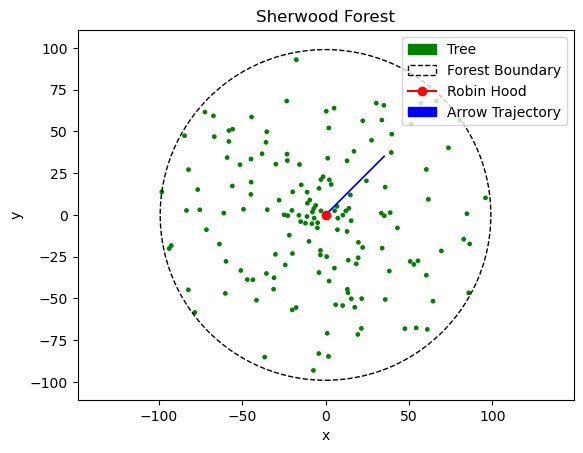

In [25]:
forest = generateForest(dR=100)[1]
plotForest(forest, np.pi/4, 50)

Looks great!

## 2.

Now we need to implement the shooting of the arrow and find the length it travels before hitting a tree. We can represent the trajectory of the arrow with a line $l$ given by $y = a x + b$. We can then use the formula for the distance from a point to a line to get the distance from the center of a tree at $C=(x_C, y_C)$ to $l$:  

$\text{dist}(C, l) = \dfrac{|a x_C + b - y_C|}{\sqrt{a^2 + 1}}$  

Obviously, if this distance is less than the radius of the tree, the arrow will hit it. This will be our condition for detecting collisions.

If we do hit a tree, we also need to find the point of intersection. Combining the equation of the circle representing the tree with the equation for $l$ at the point of intersection $(x_0, y_0)$ yields:

$(x_0 - x_C)^2 + (a x_0 + b - y_C)^2 = R^2$

Which is a quadratic equation $A x_0^2 + B x_0 + C = 0$ with the following coefficients:  

$A = a^2 + 1$  
$B = 2 a b - 2 a y_C -2 x_C$  
$C = -R^2 +b^2 -2 b y_C + x_C^2 +y_C^2$

So the points of intersection are:

$\left(\dfrac{-B \pm \sqrt{B^2 - 4 A C}}{2 A}, a\left[\dfrac{-B \pm \sqrt{B^2 - 4 A C}}{2 A}\right] + b \right)$

We can simply calculate both possible points of intersection and return the one closest to the origin.

As the arrow can only travel in one direction along the line, we'll need to make sure we only check one ''side'' of the line. Otherwise we might detect collisions with the part of the line that is opposite the arrow's direction of travel. This can be done by comparing the angle the path of the arrow makes with the origin and that of the trees.  

Finally, we need to ensure that we check the trees closest to the origin first. It wouldn't do to abort the loop because we found a collision with some faraway tree, possibly ignoring a collision closer to the origin. Fortunately, we've made our Tree objects sortable by their distance to the origin.

In [26]:
def shootArrow(theta=0, sigma=0.005, D=2, R=0, dR=10):
    '''
    Shoots an arrow at an angle theta with the positive x-axis and determines how far it travels before hitting a tree.

    Parameters:
    theta: The angle with the positive x-axis at which the arrow was fired
    sigma: The density of trees measured in trees pr. unit area
    D: The diameter of the trees in the forest
    R: The distance from the origin at which the first ring will begin
    dR: The thickness of the rings

    Returns a tuple containing the distance to the point of intersection and the forest associated with the arrow.
    '''
    
    # Slope of the line
    a = np.tan(theta)
    b = 0 # Since we're shooting from the origin

    old_forest = []

    while True:
        # Generate some new forest for the arrow
        old_forest, added_forest_ring = generateForest(sigma, D, R, dR, old_forest)
        current_forest = mergeForests(old_forest, added_forest_ring)

        old_forest = current_forest # Update the old forest to include the new trees before the next iteration of the loop

        # We sort the newly generated trees from closest to furthest from the origin
        added_forest_ring.sort()

        # Only check the newly generated trees
        for tree in added_forest_ring:
            # Check if the tree is in the direction in which the arrow is traveling
            if (theta - np.pi/2) <= tree.arg <= (theta + np.pi/2):
                # If the trajectory of the arrow intersects the tree, return the distance the arrow flew
                if distToLine(a, b, tree.x_pos, tree.y_pos) <= tree.diameter / 2:
                    intersection = line_circleIntersection(a, b, tree.x_pos, tree.y_pos, tree.diameter / 2)
                    tree.color = 'red' # Makes it easier to see which tree was hit
                    
                    return (distance(intersection[0], intersection[1], 0, 0), current_forest)
        
        # If we haven't hit anything after trying all of the trees, we generate another ring of the forest at the edge of the current one and try again
        R += dR

    

Let's see if it works.

The arrow traveled approximately 581 units before hitting a tree.


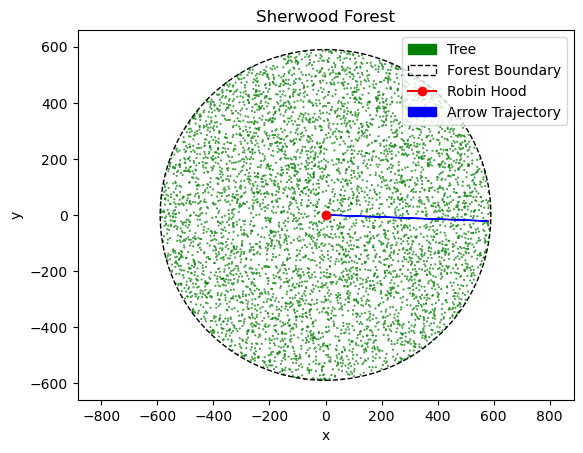

In [27]:
theta = np.random.uniform(0, 2*np.pi)
dist, forest = shootArrow(theta, sigma=0.005, dR=10)
print(f"The arrow traveled approximately {round(dist)} units before hitting a tree.")
plotForest(forest, theta, dist)

It does! Awesome.

## 3.1

Before we start shooting tons of arrows and doing statistics, let's try to predict what $L$ will be.

Consider the tree density, $\sigma$:  

$\sigma = \dfrac{N}{A}$

where $N$ is the number of trees in some area $A$. To find the the area that would contain just one tree on average, we set $N = 1$:

$A = \dfrac{1}{\sigma}$

The way we have modelled collisions between the arrow and the trees, we are essentially imagining the arrow having a 2d equivalent of a ''cross-sectional area'', $D$. It sweeps out a rectangle as it moves forward, and if any tree centers are located within that rectangle, we detect a collision (I believe this is similar to how interactions are modelled in particle physics?). If the arrow moves a distance $L$, the area it sweeps out is:

$A_L = L D$

To find the expected value for $L$, we proceed similarly to how one would find the mean free path of a particle in 3d space and ask ourselves: How far will the arrow have to travel to sweep out the area where we would expect to find one tree?  

$A_L = L D = \dfrac{1}{\sigma}$

$\implies L = \dfrac{1}{\sigma D}$

Let's see if this prediction is correct!

## 3.2

In [28]:
# Our prediction
def L_func(sigma, D):
    return 1 / (sigma * D)

In [29]:
def repeatedArrowShooting(sigma=0.005, D=2, R=0, dR=10, n_arrows=5):
    '''
    Shoots n_arrows arrows at random angles and determines how far each arrow travels before hitting a tree.

    Parameters:
    sigma: The density of trees measured in trees pr. unit area
    D: The diameter of the trees in the forest
    R: The distance from the origin at which the first ring will begin
    dR: The thickness of the rings
    n_arrows: The number of arrows to shoot

    Returns a list of tuples containing the forest, angle and distance for each arrow.
    '''
    
    results = []

    for i in range(n_arrows):
        theta = np.random.uniform(0, 2*np.pi)
        dist, forest = shootArrow(theta, sigma, D, R, dR)
        results.append((forest, theta, dist))
    
    return results


In [30]:
def arrowStats(results):
    '''
    Calculates the mean distance an arrow travels before hitting a tree.
    
    Takes in a list of results from repeatedArrowShooting() and returns the mean distance and the error on the mean.
    '''
    distances = [result[2] for result in results]
    mean = np.mean(distances)
    error = np.std(distances)/np.sqrt(len(distances))
    return (mean, error)


In the first assignment I was critized for not using functions for this kind of thing, so here you go :p

In [31]:
def computeSigmaResults(sigma_vals, dR, n_arrows):
    '''Takes in a list of sigma values and computes the mean distance an arrow travels before hitting a tree for each sigma value.'''
    D = 2
    sigma_res = []
    for sigma in tqdm(sigma_vals, desc="Computing sigma results"):
        result = repeatedArrowShooting(sigma=sigma, D=D, dR=dR, n_arrows=n_arrows)
        sigma_res.append(arrowStats(result))
    return sigma_res

def computeDResults(D_vals, dR, n_arrows):
    '''Takes in a list of D values and computes the mean distance an arrow travels before hitting a tree for each D value.'''
    sigma = 0.005
    D_res = []
    for D in tqdm(D_vals, desc="Computing D results"):
        result = repeatedArrowShooting(sigma=sigma, D=D, dR=dR, n_arrows=n_arrows)
        D_res.append(arrowStats(result))
    return D_res

Computing D results: 100%|██████████| 3/3 [00:00<00:00, 44.10it/s]


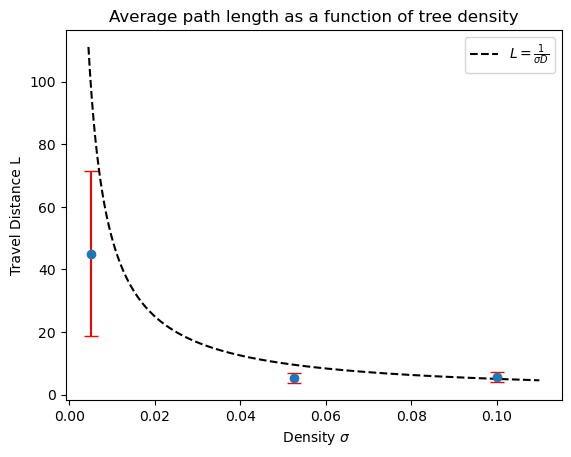

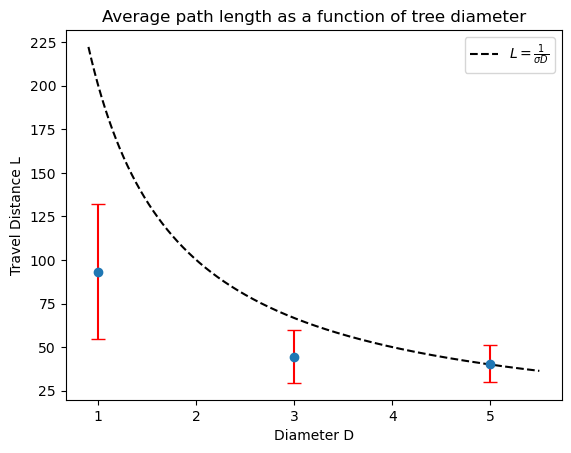

Chi-squared value for sigma: 11.64
Chi-squared value for D: 9.73


In [32]:
# Constants
n_points = 3
dR = 10
n_arrows = 3
min_sigma, max_sigma = 0.005, 0.1
min_D, max_D = 1, 5

# Generate values for sigma and D
sigma_X_vals = np.linspace(min_sigma, max_sigma, n_points)
D_X_vals = np.linspace(min_D, max_D, n_points)

# Compute results for sigma and D ranges
sigma_res = computeSigmaResults(sigma_X_vals, dR=dR, n_arrows=n_arrows)
D_res = computeDResults(D_X_vals, dR=dR, n_arrows=n_arrows)

# Separate the Y values and errors into their own lists
sigma_res_Y = [res[0] for res in sigma_res]
sigma_res_Y_err = [res[1] for res in sigma_res]

D_res_Y = [res[0] for res in D_res]
D_res_Y_err = [res[1] for res in D_res]

# Generate data for plotting L as a function of sigma and D
L_func_X_sigma = np.linspace(min_sigma * 0.9, max_sigma * 1.1, 1000)
L_func_X_D = np.linspace(min_D * 0.9, max_D * 1.1, 1000)

# Plot the results for sigma
plt.figure()
plt.errorbar(sigma_X_vals, sigma_res_Y, yerr=sigma_res_Y_err, ecolor='red', capsize=5, fmt='o')
plt.xlabel(r' Density $\sigma$')
plt.ylabel('Travel Distance L')
plt.title('Average path length as a function of tree density')
plt.plot(L_func_X_sigma, L_func(L_func_X_sigma, 2), linestyle="dashed", color="black", label=r'$L = \frac{1}{\sigma D}$')
plt.legend()
plt.show()

# Plot the results for D
plt.figure()
plt.errorbar(D_X_vals, D_res_Y, yerr=D_res_Y_err, ecolor='red', capsize=5, fmt='o')
plt.xlabel('Diameter D')
plt.ylabel('Travel Distance L')
plt.title('Average path length as a function of tree diameter')
plt.plot(L_func_X_D, L_func(0.005, L_func_X_D), linestyle="dashed", color='black', label=r'$L = \frac{1}{\sigma D}$')
plt.legend()
plt.show()

# Calculate chi-squared values
chi_squared_sigma = chiSquared(sigma_res_Y, L_func(sigma_X_vals, 2), sigma_res_Y_err)
chi_squared_D = chiSquared(D_res_Y, L_func(0.005, D_X_vals), D_res_Y_err)

# Print chi-squared values
print(f"Chi-squared value for sigma: {round(chi_squared_sigma, 2)}")
print(f"Chi-squared value for D: {round(chi_squared_D, 2)}")

That took quite a while, even for only 3 points with 3 arrows per point (and I'm using a beefy gaming PC!) 

We'll need way more points to get better statistics. If we want those results before 2025, we'll need to optimize our code.

In a sense, shooting an arrow in a random direction in a randomized forest is a bit redundant. Shooting an arrow in a fixed direction and changing the forest would have the same effect.  

If we choose to always shoot the arrow in the positive x direction for instance, we can limit our forest generation to only generate trees along that direction. In fact, we could limit it to only generate trees if they are within one tree radius of the arrow on either side. That way we would only be generating trees that can be hit by the arrow. So we would only need to generate one tree per arrow!

In [ ]:
def generateForestOptimized(sigma=0.005, D=2, X=0, rect_length=2, old_forest=[]):
    '''
    This generates a patch of forest in a rectangle along the trajectory of the arrow. Assumes the arrow is shot along the positive x-axis. Assumes theta = 0!

    Parameters:
    sigma: The density of trees measured in trees pr. unit area
    D: The diameter of the trees in the forest
    X: The distance from the origin at which the rectangle will begin
    rect_length: The length of the rectangle in units of 1/(D*sigma)
    old_forest: An existing forest

    Returns a nested list of Tree objects, containing the trees in the old forest and the trees in the new rectangle.
    '''
    # The width of our rectangle. Cannot be less than D, as that would in principle allow trees to be within one radius of the arrow without hitting it
    # A width of D corresponds to only generating trees that can be hit by the arrow
    width = D

    # We can simply set dX to some multiple of the expected path length instead of leaving it as a parameter
    dX = rect_length/(D*sigma)

    # Calculate the area of the rectangle and the number of trees to place
    area = dX*width
    n_trees = int(sigma*area)

    added_forest_rect = []

    while len(added_forest_rect) < n_trees:
        new_tree = Tree()

        # Get random position for new tree
        x = np.random.uniform(X, X + dX)
        y = np.random.uniform(-width/2, width/2)

        origin_dist = distance(x, y, 0, 0)

        # As before, we avoid placing trees on top of each other or at the origin (the first of these considerations is of course unnecessary if we use width=D, but I've left it in for generality)
        if all(distance(x, y, tree.x_pos, tree.y_pos) >= D for tree in old_forest) and all(distance(x, y, tree.x_pos, tree.y_pos) >= D for tree in added_forest_rect) and origin_dist > D:
            new_tree.setDiameter(D)
            new_tree.setPosition(x, y)
            new_tree.setOriginDistance(origin_dist)
            new_tree.setArgument(theta)
            new_tree.setColor('green')

            added_forest_rect.append(new_tree)
            
    return [old_forest, added_forest_rect]


In [ ]:
def shootArrowOptimized(sigma=0.005, D=2, X=0, rect_length=2):
    '''
    Similar to shootArrow(), but uses optimized forest generation.

    Shoots an arrow along the positive x-axis and determines how far it travels before hitting a tree.

    Parameters:
    sigma: The density of trees measured in trees pr. unit area
    D: The diameter of the trees in the forest
    X: The distance from the origin at which the rectangle will begin
    rect_length: The length of the rectangle in units of 1/(D*sigma) (our prediction for the path length)

    Returns a tuple containing the distance to the point of intersection and the forest associated with the arrow.
    '''
    
    # This time both a and b are zero
    a = 0
    b = 0

    old_forest = []

    while True:
        # Generate some new forest for the arrow
        old_forest, added_forest_rect = generateForestOptimized(sigma, D, X, rect_length, old_forest)
        current_forest = mergeForests(old_forest, added_forest_rect)
        # We sort the trees from closest to furthest from the origin
        added_forest_rect.sort()

        old_forest = current_forest

        # Only check the newly generated trees
        for tree in added_forest_rect:
            # If the trajectory of the arrow intersects the tree, return the distance the arrow flew
            if distToLine(a, b, tree.x_pos, tree.y_pos) <= tree.diameter / 2:
                intersection = line_circleIntersection(a, b, tree.x_pos, tree.y_pos, tree.diameter / 2)
                tree.color = 'red' # Makes it easier to see which tree was hit
                return (distance(intersection[0], intersection[1], 0, 0), current_forest)
        
        # If we haven't hit anything after trying all of the trees, we generate another rectangle of forest ahead of the current one and try again
        X += rect_length

    

In [ ]:
def repeatedArrowShootingOptimized(sigma=0.005, D=2, X=0, rect_length=2, n_arrows=5):
    '''
    Similar to repeatedArrowShooting, but uses the optimized versions of shootArrow and generateForest.

    Parameters:
    sigma: The density of trees measured in trees pr. unit area
    D: The diameter of the trees in the forest
    X: The distance from the origin at which the first rectangle will begin
    rect_length: The length of the rectangles generated by generateForestOptimized() in units of 1/(D*sigma)
    n_arrows: The number of arrows to shoot

    Returns a list of tuples containing the forest, angle and distance for each arrow.
    '''
    
    results = []

    for i in range(n_arrows):
        dist, forest = shootArrowOptimized(sigma, D, X, rect_length)
        results.append((forest, theta, dist))
    
    return results


In [ ]:
def computeSigmaResultsOptimized(sigma_vals, n_arrows, rect_length):
    '''
    Takes in a list of sigma values and computes the mean distance an arrow travels before hitting a tree for each sigma value.
    
    Uses the optimized version of the functions.
    '''
    D = 2
    sigma_res = []
    for sigma in tqdm(sigma_vals, desc="Computing sigma results"):
        result = repeatedArrowShootingOptimized(sigma=sigma, D=D, rect_length=rect_length, n_arrows=n_arrows)
        sigma_res.append(arrowStats(result))
    return sigma_res

def computeDResultsOptimized(D_vals, n_arrows, rect_length):
    '''
    Takes in a list of D values and computes the mean distance an arrow travels before hitting a tree for each D value.
    
    Uses the optimized version of the functions.
    '''
    sigma = 0.005
    D_res = []
    for D in tqdm(D_vals, desc="Computing D results"):
        result = repeatedArrowShootingOptimized(sigma=sigma, D=D, rect_length=rect_length, n_arrows=n_arrows)
        D_res.append(arrowStats(result))
    return D_res

I've updated shootArrow() and repeatedArrowShooting() to use our new generating function. Fingers crossed!

In [37]:
def runSimulation(n_points=10, n_arrows=10, rect_length=2, min_sigma=0.001, max_sigma=0.01, min_D=0.1, max_D=10):
    # Generate values for sigma and D
    sigma_X_vals = np.linspace(min_sigma, max_sigma, n_points)
    D_X_vals = np.linspace(min_D, max_D, n_points)

    # Compute results for sigma and D ranges
    sigma_res = computeSigmaResultsOptimized(sigma_X_vals, n_arrows=n_arrows, rect_length=rect_length)
    D_res = computeDResultsOptimized(D_X_vals, n_arrows=n_arrows, rect_length=rect_length)

    # Separate the Y values and errors into their own lists
    sigma_res_Y = [res[0] for res in sigma_res]
    sigma_res_Y_err = [res[1] for res in sigma_res]

    D_res_Y = [res[0] for res in D_res]
    D_res_Y_err = [res[1] for res in D_res]

    # Generate data for plotting L as a function of sigma and D
    L_func_X_sigma = np.linspace(min_sigma * 0.9, max_sigma * 1.1, 1000)
    L_func_X_D = np.linspace(min_D * 0.9, max_D * 1.1, 1000)

    # Calculate chi-squared values
    chi_squared_sigma = chiSquared(sigma_res_Y, L_func(sigma_X_vals, 2), sigma_res_Y_err)
    chi_squared_D = chiSquared(D_res_Y, L_func(0.005, D_X_vals), D_res_Y_err)

    # Print chi-squared values
    print(f"Chi-squared value for sigma: {round(chi_squared_sigma, 2)}")
    print(f"Chi-squared value for D: {round(chi_squared_D, 2)}")

    # Plot the results for sigma
    plt.figure()
    plt.errorbar(sigma_X_vals, sigma_res_Y, yerr=sigma_res_Y_err, ecolor='red', capsize=5, fmt='o')
    plt.xlabel(r' Density $\sigma$')
    plt.ylabel('Travel Distance L')
    plt.title('Average path length as a function of tree density')
    plt.plot(L_func_X_sigma, L_func(L_func_X_sigma, 2), linestyle="dashed", color="black", label=r'$L = \frac{1}{\sigma D}$')
    plt.legend()
    plt.show()

    # Plot the results for D
    plt.figure()
    plt.errorbar(D_X_vals, D_res_Y, yerr=D_res_Y_err, ecolor='red', capsize=5, fmt='o')
    plt.xlabel('Diameter D')
    plt.ylabel('Travel Distance L')
    plt.title('Average path length as a function of tree diameter')
    plt.plot(L_func_X_D, L_func(0.005, L_func_X_D), linestyle="dashed", color='black', label=r'$L = \frac{1}{\sigma D}$')
    plt.legend()
    plt.show()

Computing D results: 100%|██████████| 100/100 [00:00<00:00, 203.16it/s]


Chi-squared value for sigma: 286.67
Chi-squared value for D: 235.74


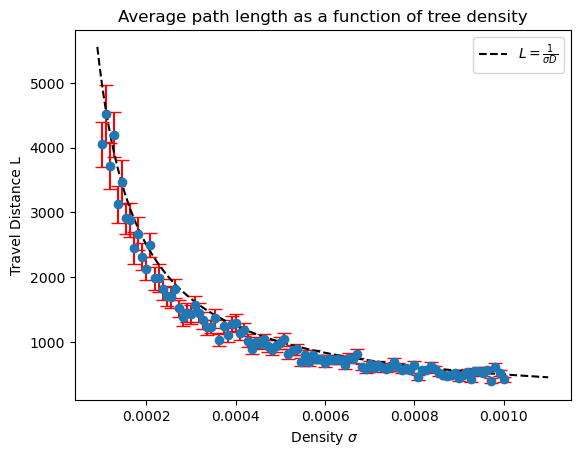

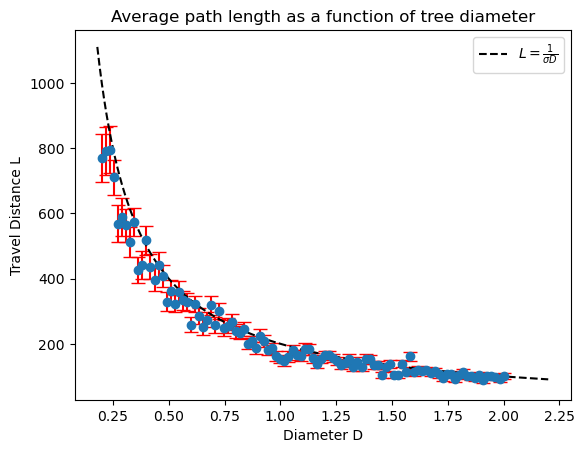

In [ ]:
runSimulation(n_points=1, n_arrows=150, rect_length=10, min_sigma=0.0001, max_sigma=0.001, min_D=0.2, max_D=2)

It seems like our prediction was correct! The $\chi^2$-values are close to the amount of data points, which indicates a good model.

You may recall that the rect_length parameter controls how far ahead we generate trees in generateForestOptimized, measured in units of our predicted path length $L=\dfrac{1}{D \sigma}$. After playing around with this parameter, I noticed that lower values (close to 1) resulted in the actual travel distance being consistently lower than expected. This improved up to a rect_length of about 10, after that there was no noticable improvement. I'm not sure why this is the case, perhaps it has something to do with the rounding we do when calculating the number of trees to place based on the area of the rectangle.